In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lab2_proto import *
from prondict import prondict
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# 3) Data and Model set

In [2]:
data = np.load('lab2_data.npz', allow_pickle=True)['data']
#phoneHMMs = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
phoneHMMs = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()

In [3]:
list(sorted(phoneHMMs.keys()))

['ah',
 'ao',
 'ay',
 'eh',
 'ey',
 'f',
 'ih',
 'iy',
 'k',
 'n',
 'ow',
 'r',
 's',
 'sil',
 'sp',
 't',
 'th',
 'uw',
 'v',
 'w',
 'z']

In [4]:
phoneHMMs['ah'].keys()

dict_keys(['name', 'startprob', 'transmat', 'means', 'covars'])

# 4) Concatenating HMMs

In [5]:
isolated = {}
for digit in prondict.keys():
    isolated[digit] = ['sil'] + prondict[digit] + ['sil']

print(isolated['o'])

['sil', 'ow', 'sil']


In [6]:
wordHMMs = {}
wordHMMs['o'] = concatHMMs(phoneHMMs, isolated['o'])
#wordHMMs['o']

In [7]:
example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()
list(example.keys())

['filename',
 'samplingrate',
 'gender',
 'speaker',
 'digit',
 'repetition',
 'samples',
 'lmfcc',
 'obsloglik',
 'logalpha',
 'loglik',
 'vloglik',
 'vpath',
 'logbeta',
 'loggamma']

In [8]:
means = wordHMMs['o']['means']
covars = wordHMMs['o']['covars']
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], means, covars)
#(example['obsloglik'] - log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars']))[:4]

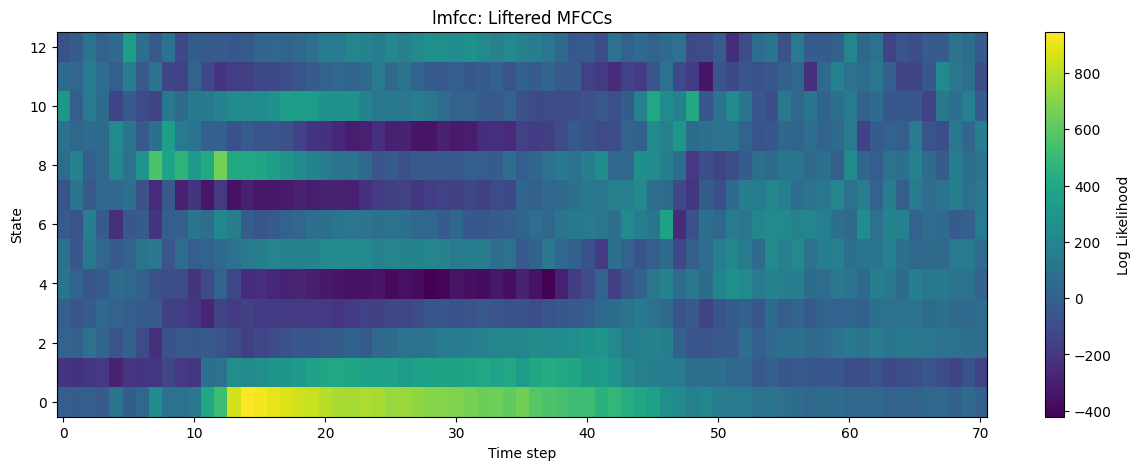

In [9]:
plt.figure(figsize=(15, 5))
plt.imshow(example['lmfcc'].T, aspect='auto', origin='lower', cmap='viridis', interpolation='none')
plt.colorbar(label='Log Likelihood')
plt.xlabel('Time step')
plt.ylabel('State')
plt.title('lmfcc: Liftered MFCCs')
plt.show()

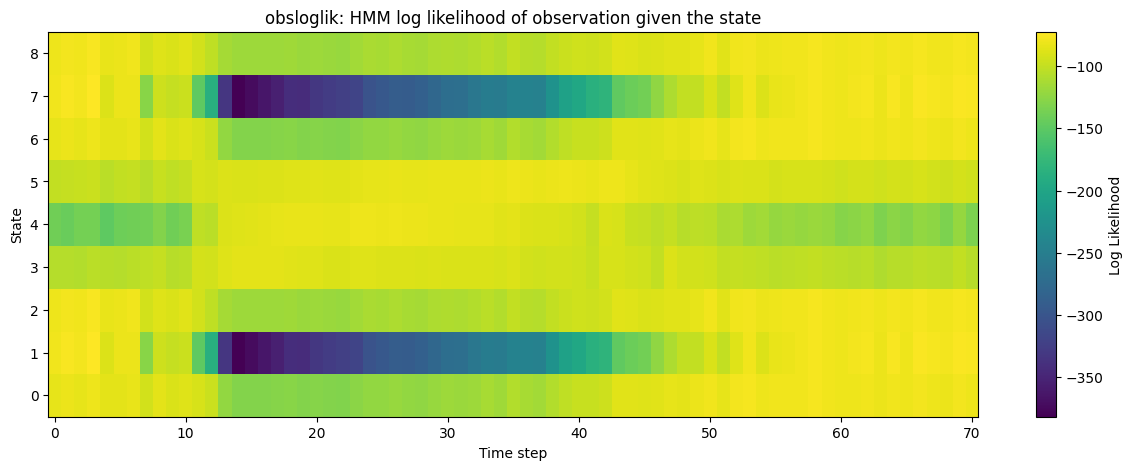

In [10]:
plt.figure(figsize=(15, 5))
plt.imshow(obsloglik.T, aspect='auto', origin='lower', cmap='viridis', interpolation='none')
plt.colorbar(label='Log Likelihood')
plt.xlabel('Time step')
plt.ylabel('State')
plt.title('obsloglik: HMM log likelihood of observation given the state')
plt.show()

* What can you say about the figure? \
answer

* Which Gaussian components give the high likelihood in which time steps? Why? Remember that each utterance starts and ends with silence. \
answer

In [11]:
data = np.load('lab2_data.npz', allow_pickle=True)['data']

# Forward algorithm - Evaluate an HMM

The Forward algorithm is a dynamic programming approach to calculate the likelihood P(X|theta) of an observation sequence X = (X1, X2, ..., XT) given the HMM theta. The algorithm proceeds sequentially over the sequence, computing forward probabilities that represent the joint probability of observing a particular subsequence of data and being in a specific state of the model at each time step.

In [12]:
logalpha = forward(example['obsloglik'], np.log(wordHMMs['o']['startprob']), np.log(wordHMMs['o']['transmat']))
#logalpha - example['logalpha']

In [13]:
word_hmms = {}
for digit in prondict.keys():
    word_hmms[digit] = concatHMMs(phoneHMMs, ['sil'] + prondict[digit] + ['sil'])

data = np.load('lab2_data.npz', allow_pickle=True)['data']
#data.shape # (44,)

In [14]:
optimal_hmm = {}
successful_pred = 0
for i, df in enumerate(data):
    max_log_likelihood = None
    for digit in word_hmms.keys():
        means, covars = word_hmms[digit]['means'], word_hmms[digit]['covars']
        startprob, transmat = word_hmms[digit]['startprob'], word_hmms[digit]['transmat']

        obsloglik = log_multivariate_normal_density_diag(df['lmfcc'], means, covars)
        logalpha = forward(obsloglik, np.log(startprob), np.log(transmat))
        loglik = logsumexp(logalpha[-1])

        if max_log_likelihood is None or max_log_likelihood < loglik:
            optimal_hmm[i] = digit
            max_log_likelihood = loglik
    if df['digit'] == optimal_hmm[i]:
        successful_pred += 1

acc = np.round(successful_pred / len(data) * 100, 1)
print("Accuracy forward algorithm: " + str(acc))

Accuracy forward algorithm: 97.7


* Do you see any mistakes if you take the maximum likelihood model as winner? \
answer

* Compare the results obtained from the models trained on a single speaker or all the training speakers. \
answer

# Viterbi algorithm - Decode an HMM

The Viterbi algorithm is a dynamic programming algorithm for finding the most probable sequence of hidden states—called the Viterbi path—that results in a sequence of observed events, especially in the context of Markov information sources and hidden Markov models (HMM).

The accuracy of the predictions has been: 100.0


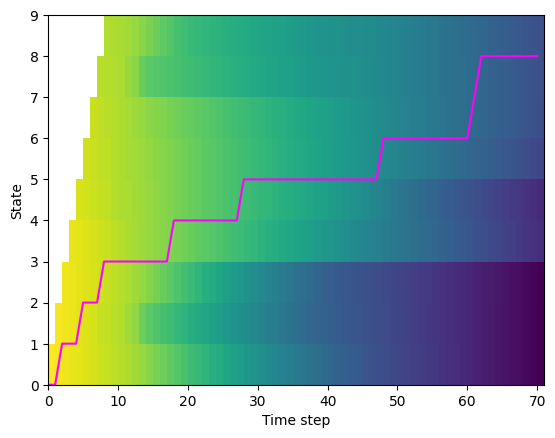

In [19]:
optimal_hmm = {}
successful_pred = 0
for i, df in enumerate(data):
    max_log_likelihood = None
    for digit in word_hmms.keys():
        means, covars = word_hmms[digit]['means'], word_hmms[digit]['covars']
        startprob, transmat = word_hmms[digit]['startprob'], word_hmms[digit]['transmat']

        obsloglik = log_multivariate_normal_density_diag(df['lmfcc'], means, covars)
        viterbi_loglik, viterbi_path = viterbi(obsloglik, np.log(startprob), np.log(transmat))
        if max_log_likelihood is None or max_log_likelihood < viterbi_loglik:
            optimal_hmm[i] = digit
            max_log_likelihood = viterbi_loglik
    if df['digit'] == optimal_hmm[i]:
        successful_pred += 1

acc = np.round(successful_pred / len(data) * 100, 1)
print("The accuracy of the predictions has been: " + str(acc))

startprob_o = word_hmms['o']['startprob']
transmat_o = word_hmms['o']['transmat']

logalpha = forward(example['obsloglik'], np.log(startprob_o), np.log(transmat_o))
vloglik, viterbi_path = viterbi(example['obsloglik'], np.log(startprob_o), np.log(transmat_o))

plt.pcolormesh(logalpha.T)
plt.plot(viterbi_path.T, color="magenta")
plt.xlabel('Time step')
plt.ylabel('State')
plt.show()

* How many mistakes can you count if you take as winner the model with the maximum viterbi score? \
answer

* Are these the same mistakes obtained in previous section? \
ans

* Can you say something about the complexity of the viterbi scoring compared to the forward scoring (for example by measuring the CPU usage?) \
ans